# Project - Solar Energy Production Forecasting
## Part 1 - Load data + EDA

Steps:
- Load train and test datasets
- Ensure chronological order (no shuffling)
- Create a 70/30 Train/Validation split **by time**
- Perform minimal sanity checks (shape, missing values, target leakage)

In [20]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#loading datasets and basic checks
TRAIN_URL = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
TEST_URL  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

display(train_df.head())
display(test_df.head())

Train shape: (176505, 17)
Test shape : (59376, 17)


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2020-01-04 00:00:00+00:00,0,0.0,0.0,N,4.0,1.23,17.21,1.0,0.0,0.0,2.5,277.0,0,2.0,84.0,5.04
1,2020-01-04 01:00:00+00:00,0,0.0,0.0,N,4.0,0.28,17.39,1.0,0.0,-0.3,1.8,290.0,0,2.0,86.0,5.40
2,2020-01-04 02:00:00+00:00,0,0.0,0.0,N,4.0,-0.89,18.57,0.0,0.0,-0.7,0.9,297.0,0,2.0,89.0,5.76
3,2020-01-04 03:00:00+00:00,0,0.0,0.0,N,4.0,-1.96,19.75,0.0,0.0,-1.1,0.1,300.0,0,2.0,92.0,6.12
4,2020-01-04 04:00:00+00:00,0,0.0,0.0,N,3.0,-2.30,19.93,0.0,0.0,-1.4,-0.2,299.0,0,2.0,92.0,6.12


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2021-08-26 00:00:00+00:00,0,0.004,0.004,N,8.0,17.50,21.32,0.0,0.0,13.1,17.5,345.0,0,7.0,76.0,6.48
1,2021-08-26 01:00:00+00:00,0,0.004,0.004,N,8.0,17.10,19.41,0.0,0.0,13.0,17.1,341.0,0,7.0,77.0,6.12
2,2021-08-26 02:00:00+00:00,0,0.004,0.004,N,6.0,16.50,20.50,0.0,0.0,12.8,16.5,341.0,0,7.0,79.0,5.76
3,2021-08-26 03:00:00+00:00,0,0.004,0.004,N,6.0,15.80,20.58,0.0,0.0,12.6,15.8,342.0,0,7.0,81.0,5.40
4,2021-08-26 04:00:00+00:00,0,0.004,0.004,D,6.0,15.65,22.67,0.0,0.0,12.5,15.2,359.0,0,8.0,84.0,5.04


In [13]:
#parsing dates
time_col = 'UTC Time'

train_df[time_col] = pd.to_datetime(train_df[time_col], errors="coerce")
test_df[time_col]  = pd.to_datetime(test_df[time_col], errors="coerce")

train_df = train_df.sort_values(time_col).reset_index(drop=True)
test_df  = test_df.sort_values(time_col).reset_index(drop=True)

In [7]:
#checking for missing values

def missing_report(df, name='df'):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss>0]
    print(f"\nMissingness report — {name}")
    if len(miss) == 0:
        print("No missing values")
        return
    display((miss * 100) * 100).round(2).to_fram('% of missing values')

missing_report(train_df, "train_df")
missing_report(test_df, "test_df")


Missingness report — train_df
No missing values

Missingness report — test_df
No missing values


In [17]:
#joining both dfs for EDA
df = pd.concat([train_df, test_df], join="inner").sort_values("UTC Time").sort_values("Plant_ID")
df.shape

(235881, 17)

In [18]:
df.head()

,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2020-01-04 00:00:00+00:00,0,0.0,0.0,N,4.0,1.23,17.21,1.0,0.00,0.0,2.5,277.0,0,2.0,84.0,5.04
176115,2021-04-29 21:00:00+00:00,0,0.0,0.0,N,6.0,14.72,9.37,25.0,0.02,13.3,14.7,17.0,2,17.0,91.0,6.84
176134,2021-04-29 22:00:00+00:00,0,0.0,0.0,N,6.0,14.09,8.74,31.0,0.02,13.0,14.1,10.0,2,17.0,93.0,6.48
176157,2021-04-29 23:00:00+00:00,0,0.0,0.0,N,6.0,13.40,4.00,32.0,0.04,12.9,13.5,287.0,4,18.0,96.0,6.48
41816,2020-04-23 21:00:00+00:00,0,0.0,0.0,N,6.0,12.49,24.88,1.0,0.00,1.8,12.9,276.0,0,4.0,47.0,7.56


In [19]:
df.describe()

,Plant_ID,Energy_Production,Benchmark,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
count,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,2.358810e+05,235881.000000,235881.000000,235881.000000
mean,7.670859,0.008685,0.008677,6.076560,11.535787,18.994054,10.469979,0.010241,6.796013,12.109901,143.582056,-3.277474e+06,9.581433,72.889347,7.436998
std,4.577249,0.014589,0.014576,1.945064,9.347031,8.756769,17.102289,0.040474,6.631462,8.387371,114.718993,8.383085e+07,4.858372,16.940525,2.438261
min,0.000000,0.000000,0.000000,3.000000,-10.240000,0.000000,0.000000,0.000000,-13.100000,-7.600000,0.000000,-2.147484e+09,1.000000,15.000000,0.160000
25%,4.000000,0.000000,0.000000,4.000000,4.200000,14.000000,1.000000,0.000000,1.800000,5.500000,37.000000,0.000000e+00,7.000000,61.000000,5.760000
50%,8.000000,0.000000,0.000000,6.000000,9.960000,19.090000,4.000000,0.000000,6.200000,10.700000,112.000000,0.000000e+00,8.000000,77.000000,7.200000
75%,12.000000,0.012000,0.012000,8.000000,18.300000,23.260000,9.000000,0.000000,12.100000,18.300000,231.000000,0.000000e+00,15.000000,87.000000,8.640000
max,15.000000,0.097000,0.097000,12.000000,39.840000,73.850000,84.000000,0.650000,22.700000,35.600000,359.000000,4.600000e+01,18.000000,99.000000,27.000000


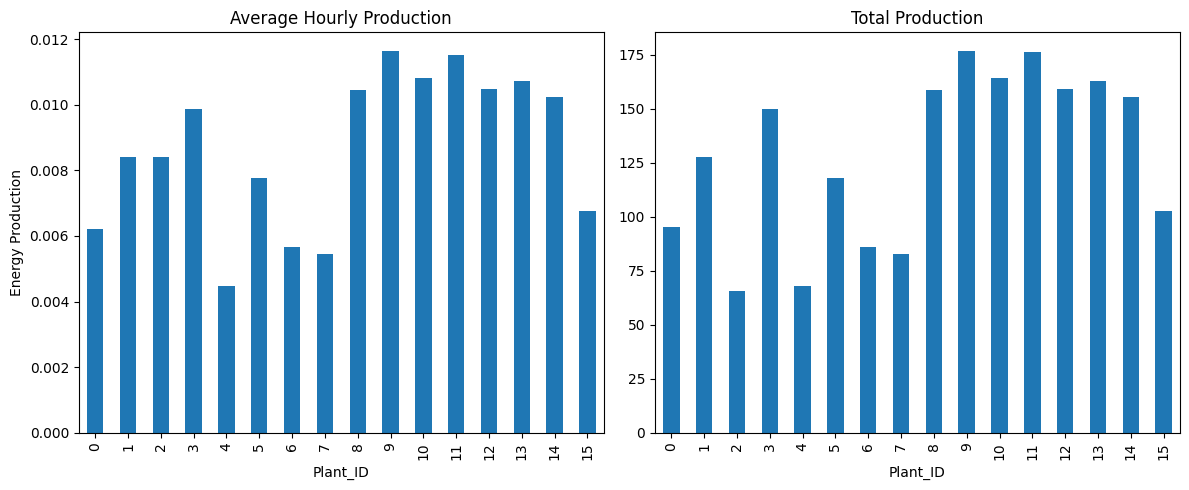

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

df.groupby('Plant_ID')['Energy_Production'].mean().plot(kind='bar', ax=axes[0], title="Average Hourly Production")
axes[0].set_ylabel("Energy Production")

df.groupby('Plant_ID')['Energy_Production'].sum().plot(kind='bar', ax=axes[1], title="Total Production")
plt.tight_layout()
plt.show()

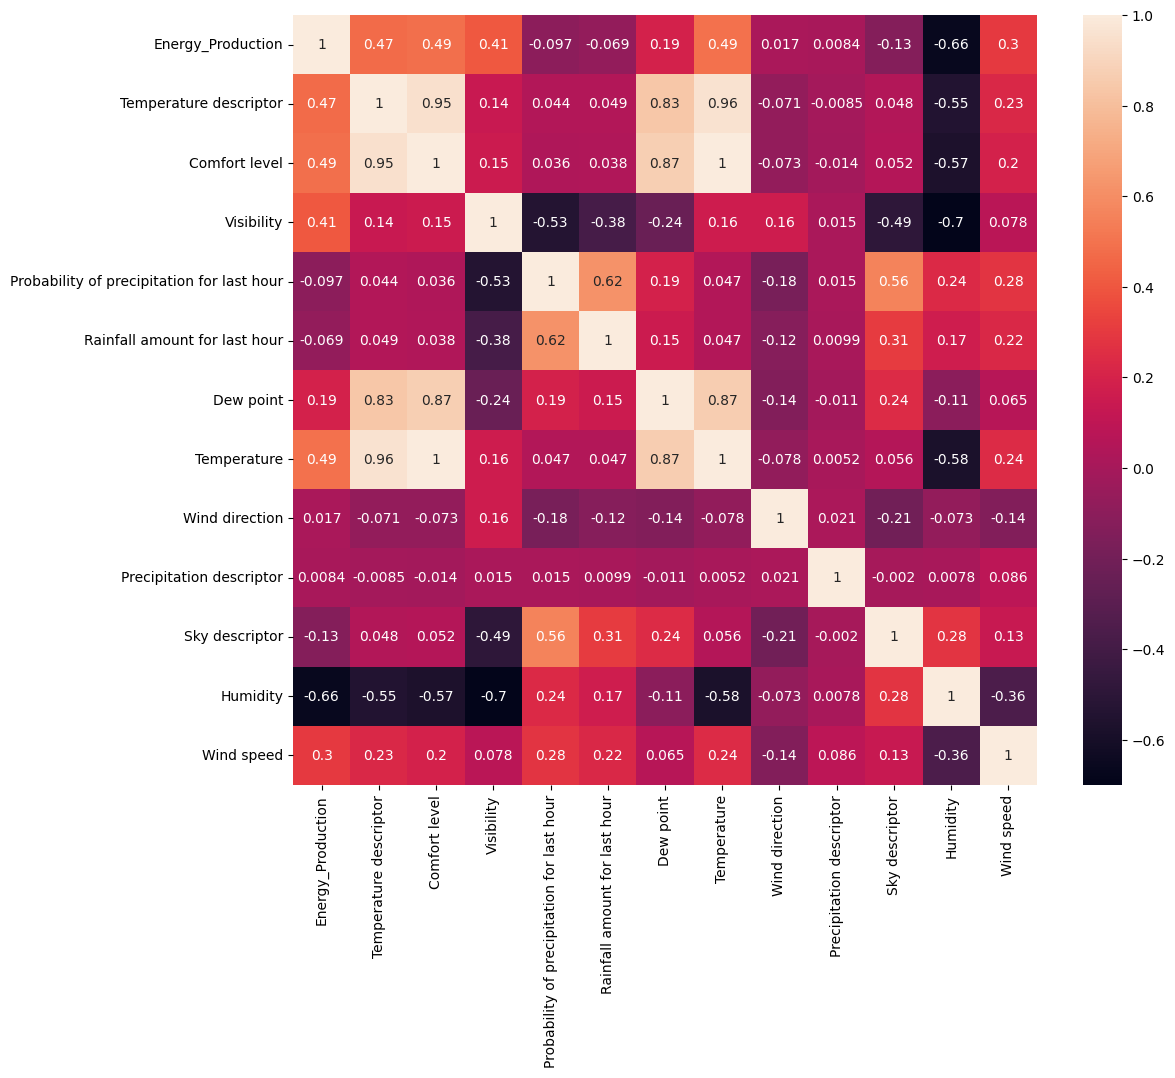

In [37]:
import seaborn as sns

corr = df[['Energy_Production',
       'Temperature descriptor', 'Comfort level', 'Visibility',
       'Probability of precipitation for last hour',
       'Rainfall amount for last hour', 'Dew point', 'Temperature',
       'Wind direction', 'Precipitation descriptor', 'Sky descriptor',
       'Humidity', 'Wind speed']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)
plt.show()

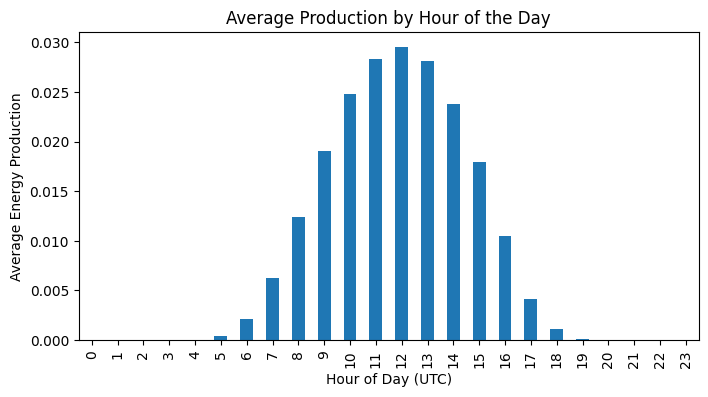

In [47]:
fig, ax = plt.subplots(figsize=(8, 4))

df['UTC Time'] = pd.to_datetime(df['UTC Time'])
df['hour'] = df['UTC Time'].dt.hour

(
    df.groupby('hour')['Energy_Production']
      .mean()
      .plot(
          kind='bar',
          ax=ax,
          title="Average Production by Hour of the Day"
      )
)

ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Average Energy Production")
plt.show()